In [1]:
# Install required packages (for Colab)
!pip install tensorflow matplotlib seaborn opencv-python

In [2]:
!python --version

Python 3.11.13


# Step 1: Dataset Selection
## I'll use the Flowers dataset (5 Classes) from
## TensorFlow Datasets.

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# Load flowers dataset
(train_ds, val_ds, test_ds), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    as_supervised=True,
    with_info=True
)

# Get class names
class_names = ds_info.features['label'].names
print("Classes:", class_names)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.49GO35_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Classes: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


# Step 2: Data Preprocessing

In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
    return image, label

train_ds = train_ds.map(format_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(format_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(format_image, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


# Step 3: Model Implementation (Transfer Learning)
## We'll use MobileNetV2 and ResNet50.

In [5]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2, ResNet50

def build_model(base_model):
    base_model.trainable = False  # Freeze base model

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [6]:
# Load pretrained base models
mobilenet_base = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
resnet_base = ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

mobilenet_model = build_model(mobilenet_base)
resnet_model = build_model(resnet_base)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#  Step 4: Train the Model

In [7]:
# Train MobileNetV2
history = mobilenet_model.fit(train_ds, validation_data=val_ds, epochs=5)

# Save model
mobilenet_model.save("mobilenetv2_flower.h5")


Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.6455 - loss: 0.9363 - val_accuracy: 0.8421 - val_loss: 0.4161
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.8829 - loss: 0.3384 - val_accuracy: 0.8784 - val_loss: 0.3462
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.9173 - loss: 0.2605 - val_accuracy: 0.8748 - val_loss: 0.3377
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.9419 - loss: 0.1925 - val_accuracy: 0.8838 - val_loss: 0.3334
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.9581 - loss: 0.1414 - val_accuracy: 0.8893 - val_loss: 0.3368


#  Step 5: Evaluation

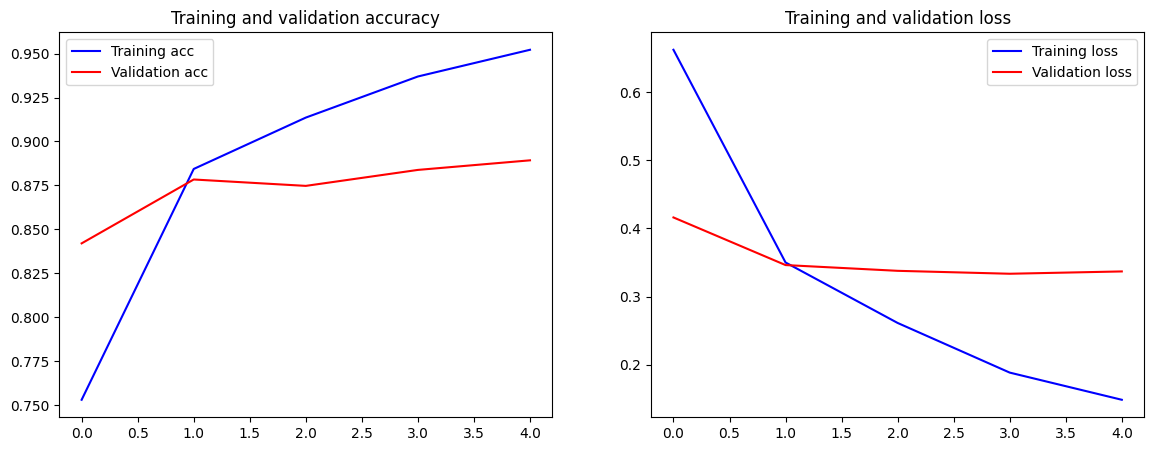

In [8]:
# Plot accuracy and loss
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(14,5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

plot_metrics(history)


# Step 6: Confusion Matrix


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


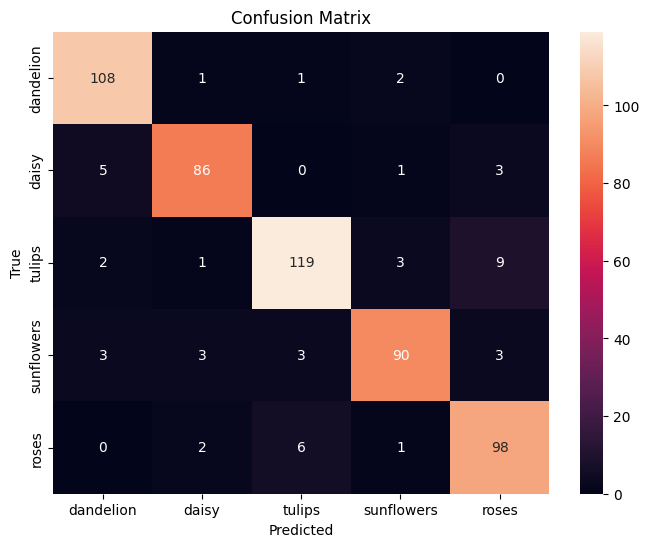

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Get predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = mobilenet_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


#  Step 7: Visualize Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


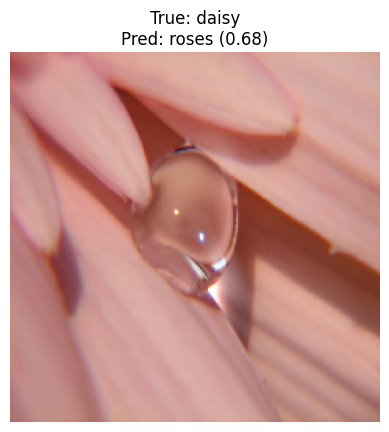

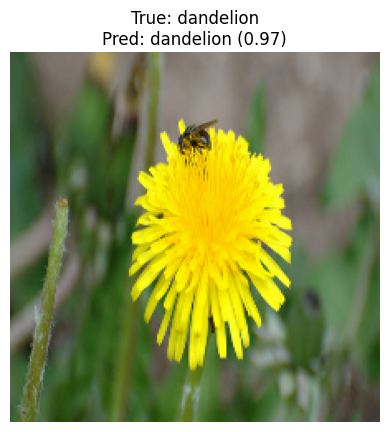

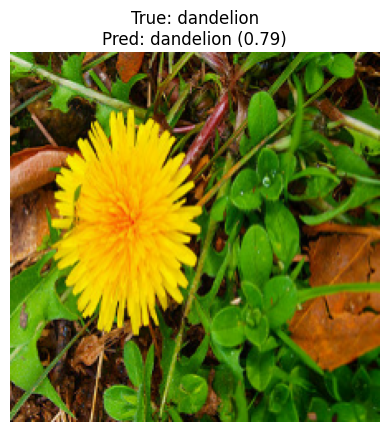

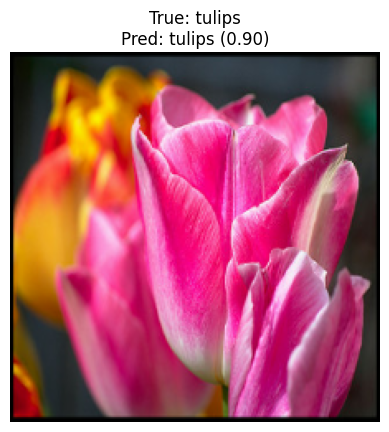

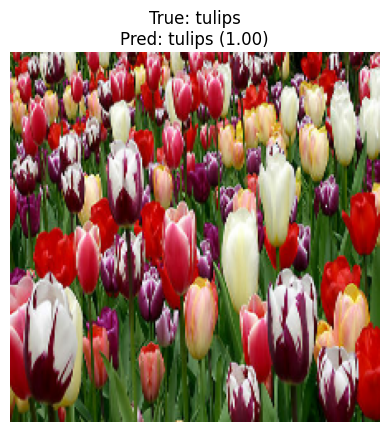

In [10]:
def show_predictions(dataset, model, class_names, num_images=5):
    for images, labels in dataset.take(1):
        preds = model.predict(images)
        for i in range(num_images):
            plt.imshow(images[i].numpy())
            plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[np.argmax(preds[i])]} ({np.max(preds[i]):.2f})")
            plt.axis('off')
            plt.show()

show_predictions(test_ds, mobilenet_model, class_names)
